# Inverting Gradients - How easy is it to break privacy in federated learning?

This notebook shows an example for a **large(r)-batch image gradient inversion** as described in "Inverting Gradients - How easy is it to break privacy in federated learning?". The setting is an untrained ResNet32-10 and the federated learning algorithm is **fedSGD**.

Paper URL: https://proceedings.neurips.cc/paper/2020/hash/c4ede56bbd98819ae6112b20ac6bf145-Abstract.html

This is basically the experiment of Fig.6 in this paper.

#### Abstract
The idea of federated learning is to collaboratively train a neural network on a server. Each user receives the current weights of the network and in turns sends parameter updates (gradients) based on local data. This protocol has been designed not only to train neural networks data-efficiently, but also to provide privacy benefits for users, as their input data remains on device and only parameter gradients are shared. But how secure is sharing parameter gradients? Previous attacks have provided a false sense of security, by succeeding only in contrived settings - even for a single image. However, by exploiting a magnitude-invariant loss along with optimization strategies based on adversarial attacks, we show that is is actually possible to faithfully reconstruct images at high resolution from the knowledge of their parameter gradients, and demonstrate that such a break of privacy is possible even for trained deep networks. We analyze the effects of architecture as well as parameters on the difficulty of reconstructing an input image and prove that any input to a fully connected layer can be reconstructed analytically independent of the remaining architecture. Finally we discuss settings encountered in practice and show that even averaging gradients over several iterations or several images does not protect the user's privacy in federated learning applications.

### Startup

In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
    
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [2]:
cfg = breaching.get_config(overrides=["case=6_large_batch_cifar"])
          
device = torch.device(f'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case large_batch_cifar with server type honest_but_curious.


{'device': device(type='cuda', index=0), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [3]:
cfg.case.data.partition="balanced" # 100 unique CIFAR-100 images
cfg.case.user.user_idx = 0

cfg.case.user.provide_labels = False
cfg.attack.label_strategy = "yin" # also works here, as labels are unique

# Total variation regularization needs to be smaller on CIFAR-10:
cfg.attack.regularization.total_variation.scale = 5e-4

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Files already downloaded and verified
Model architecture ResNet32-10 loaded with 46,429,060 parameters and 24,673 buffers.
Overall this is a data ratio of     151:1 for target shape [100, 3, 32, 32] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 100

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: CIFAR100
    user: 0
    
        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ResNet32-10
        model state: default
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.0005. p=1

### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [5]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update in model mode: eval.


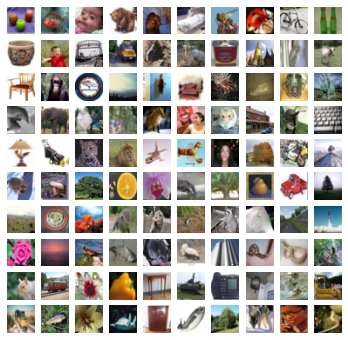

In [6]:
user.plot(true_user_data)

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

You can interrupt the computation early to see a partial solution.

In [7]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

Recovered labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] through strategy yin.
| It: 1 | Rec. loss: 0.0178 |  Task loss: 31.0118 | T: 1.23s
| It: 1001 | Rec. loss: 0.0004 |  Task loss: 26.2137 | T: 937.36s
| It: 2001 | Rec. loss: 0.0004 |  Task loss: 26.2738 | T: 930.23s
| It: 3001 | Rec. loss: 0.0004 |  Task loss: 26.1547 | T: 930.46s
| It: 4001 | Rec. loss: 0.0004 |  Task loss: 26.3437 | T: 930.56s
| It: 5001 | Rec. loss: 0.0005 |  Task loss: 26.1236 | T: 930.14s
| It: 6001 | Rec. loss: 0.0004 |  Task loss: 26.1201 | T: 930.24s
| It: 7001 | Rec. loss: 0.0004 |  Task loss: 26.2857 | T: 929.82s
| It: 8001 | Rec. loss: 0.0004 |  Task loss: 26

Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [8]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

Files already downloaded and verified
METRICS: | MSE: 0.0847 | PSNR: 11.20 | FMSE: 9.1547e+00 | LPIPS: 0.19|
 R-PSNR: 11.38 | IIP-pixel: 8.00% | SSIM: 0.3752 | max R-PSNR: 16.82 | max SSIM: 0.5652 | Label Acc: 100.00%


And finally, we also plot the reconstructed data:

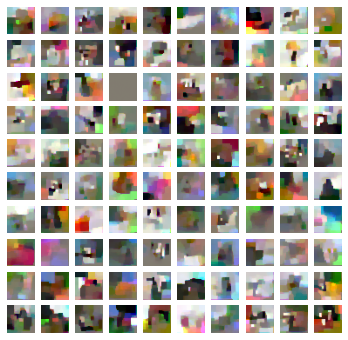

In [9]:
user.plot(reconstructed_user_data)

### Notes:
* Label recovery works reasonably well in this example. Especially as labels are unique in the default settings.
* The interesting part here is not that most images are unrecognizable (they are), but that a few select images do get reconstructed very well.
* Also note that this model is quite large for an experiment on CIFAR-100